In [1]:
import os
import random
import warnings
from sklearn.model_selection import train_test_split

import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from transformers import AutoModelForAudioClassification, Wav2Vec2FeatureExtractor

warnings.filterwarnings(action='ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
CONFIG={
    'SR':16_000,
    'SEED':42,
    'BATCH_SIZE':32, # out of Memory가 발생하면 줄여주세요
    'TOTAL_BATCH_SIZE':32, # 원하는 batch size
    'EPOCHS':50,
    'LR':1e-4,
}

In [3]:
MODEL_NAME = "Rajaram1996/Hubert_emotion"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG['SEED']) # Seed 고정

In [5]:
train_df = pd.read_csv('./train.csv')

In [6]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=CONFIG['SEED'])

In [7]:
train_df.head()
# index드롭해야한다 섞임;;

,id,path,label
4677,TRAIN_4677,./train/TRAIN_4677.wav,0
800,TRAIN_0800,./train/TRAIN_0800.wav,3
3671,TRAIN_3671,./train/TRAIN_3671.wav,2
4193,TRAIN_4193,./train/TRAIN_4193.wav,2
2968,TRAIN_2968,./train/TRAIN_2968.wav,1


In [8]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [9]:
def speech_file_to_array_fn(df):
    feature = []
    for path in tqdm(df['path']):
        speech_array, _ = librosa.load(path, sr=CONFIG['SR'])
        feature.append(speech_array)
    return feature

In [10]:
train_x = speech_file_to_array_fn(train_df)
valid_x = speech_file_to_array_fn(valid_df)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [11]:
processor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
print(processor)

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, processor):
        self.x = x
        self.y = y
        self.processor = processor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        input_values = self.processor(self.x[index], sampling_rate=CONFIG['SR'], return_tensors="pt", padding=True).input_values
        if self.y is not None:
            return input_values.squeeze(), self.y[index]
        else:
            return input_values.squeeze()

In [13]:
def collate_fn(batch):
    x, y = zip(*batch)
    x = pad_sequence([torch.tensor(xi) for xi in x], batch_first=True)
    y = torch.tensor([yi for yi in y]).unsqueeze(dim=1)
    return x, y

In [14]:
def create_data_loader(dataset, batch_size, shuffle, collate_fn, num_workers=0):
    return DataLoader(dataset,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    collate_fn=collate_fn)

train_dataset = Dataset(train_x, train_df['label'], processor)
valid_dataset = Dataset(valid_x, valid_df['label'], processor)

train_loader = create_data_loader(train_dataset, CONFIG['BATCH_SIZE'], False, collate_fn, 16)
valid_loader = create_data_loader(valid_dataset, CONFIG['BATCH_SIZE'], False, collate_fn, 16)

In [15]:
train_dataset.__getitem__(4)[0].shape

torch.Size([37904])

In [16]:
img, label=next(iter(train_loader))
print(f"The shape of the images is : {img.shape}")

The shape of the images is : torch.Size([32, 59259])


In [17]:
print(f"The shape of the labels is : {label.shape}")
print(label)

The shape of the labels is : torch.Size([32, 1])
tensor([[0],
        [3],
        [2],
        [2],
        [1],
        [4],
        [5],
        [1],
        [1],
        [2],
        [5],
        [3],
        [1],
        [4],
        [1],
        [0],
        [5],
        [2],
        [3],
        [3],
        [1],
        [2],
        [0],
        [3],
        [4],
        [0],
        [1],
        [0],
        [3],
        [1],
        [2],
        [1]])


In [18]:
audio_model = AutoModelForAudioClassification.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSequenceClassification: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN thi

In [19]:
class BaseModel(torch.nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = audio_model
        self.model.classifier = nn.Identity()
        self.classifier = nn.Linear(256, 6)

    def forward(self, x):
        output = self.model(x)
        output = self.classifier(output.logits)
        return output

In [20]:
def validation(model, valid_loader, creterion):
    model.eval()
    val_loss = []

    total, correct = 0, 0
    test_loss = 0

    with torch.no_grad():
        for x, y in tqdm(iter(valid_loader)):
            x = x.to(device)
            y = y.flatten().to(device)

            output = model(x)
            loss = creterion(output, y)

            val_loss.append(loss.item())

            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += y.size(0)
            correct += predicted.eq(y).cpu().sum()

    accuracy = correct / total

    avg_loss = np.mean(val_loss)

    return avg_loss, accuracy

In [22]:
train_losses = []
valid_losses = []
accuracys = []

def train(model, train_loader, valid_loader, optimizer, scheduler):
    accumulation_step = int(CONFIG['TOTAL_BATCH_SIZE'] / CONFIG['BATCH_SIZE'])
    model.to(device)
    creterion = nn.CrossEntropyLoss().to(device)

    best_model = None
    best_acc = 0

    for epoch in range(1, CONFIG['EPOCHS']+1):
        train_loss = []
        model.train()
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x = x.to(device)
            y = y.flatten().to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = creterion(output, y)
            loss.backward()

            if (i+1) % accumulation_step == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss.append(loss.item())

        avg_loss = np.mean(train_loss)
        valid_loss, valid_acc = validation(model, valid_loader, creterion)

        if scheduler is not None:
            scheduler.step(valid_acc)

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model

        print(f'epoch:[{epoch}] train loss:{avg_loss:.3f} valid_loss:{valid_loss:.3f} valid_acc:{valid_acc:.4f}')
        train_losses.append(avg_loss)
        valid_losses.append(valid_loss)
        accuracys.append(valid_acc)

    print(f'best_acc:{best_acc:.4f}')

    return best_model


In [23]:
model = BaseModel()
print(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LR'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

infer_model = train(model, train_loader, valid_loader, optimizer, scheduler)

BaseModel(
  (model): HubertForSequenceClassification(
    (hubert): HubertModel(
      (feature_extractor): HubertFeatureEncoder(
        (conv_layers): ModuleList(
          (0): HubertGroupNormConvLayer(
            (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (activation): GELUActivation()
            (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          )
          (1): HubertNoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (2): HubertNoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (3): HubertNoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (4): HubertNoLayerNormConvLayer(
            

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[1] train loss:0.981 valid_loss:0.634 valid_acc:0.7872


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[2] train loss:0.705 valid_loss:0.643 valid_acc:0.7852


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[3] train loss:0.606 valid_loss:0.669 valid_acc:0.7622


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[4] train loss:0.590 valid_loss:0.765 valid_acc:0.7572


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch     5: reducing learning rate of group 0 to 5.0000e-05.
epoch:[5] train loss:0.452 valid_loss:0.817 valid_acc:0.7662


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[6] train loss:0.324 valid_loss:0.740 valid_acc:0.7902


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[7] train loss:0.240 valid_loss:0.800 valid_acc:0.7852


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[8] train loss:0.220 valid_loss:0.746 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[9] train loss:0.178 valid_loss:0.824 valid_acc:0.7922


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[10] train loss:0.186 valid_loss:0.851 valid_acc:0.7912


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[11] train loss:0.165 valid_loss:0.901 valid_acc:0.7842


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 2.5000e-05.
epoch:[12] train loss:0.139 valid_loss:1.034 valid_acc:0.7652


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[13] train loss:0.093 valid_loss:0.976 valid_acc:0.7822


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[14] train loss:0.088 valid_loss:1.038 valid_acc:0.7722


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[15] train loss:0.066 valid_loss:1.090 valid_acc:0.7702


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.2500e-05.
epoch:[16] train loss:0.071 valid_loss:1.157 valid_acc:0.7672


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[17] train loss:0.051 valid_loss:0.931 valid_acc:0.7982


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[18] train loss:0.053 valid_loss:1.007 valid_acc:0.8002


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[19] train loss:0.042 valid_loss:0.967 valid_acc:0.8022


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 6.2500e-06.
epoch:[20] train loss:0.036 valid_loss:1.062 valid_acc:0.7962


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[21] train loss:0.033 valid_loss:0.982 valid_acc:0.8072


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[22] train loss:0.032 valid_loss:0.976 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[23] train loss:0.032 valid_loss:1.012 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[24] train loss:0.037 valid_loss:1.024 valid_acc:0.8082


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[25] train loss:0.025 valid_loss:1.053 valid_acc:0.8002


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[26] train loss:0.034 valid_loss:1.030 valid_acc:0.8002


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[27] train loss:0.036 valid_loss:1.009 valid_acc:0.8122


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[28] train loss:0.026 valid_loss:1.041 valid_acc:0.7942


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[29] train loss:0.027 valid_loss:1.046 valid_acc:0.7982


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[30] train loss:0.028 valid_loss:1.041 valid_acc:0.7982


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    31: reducing learning rate of group 0 to 3.1250e-06.
epoch:[31] train loss:0.024 valid_loss:1.005 valid_acc:0.8122


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[32] train loss:0.021 valid_loss:1.049 valid_acc:0.7992


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[33] train loss:0.026 valid_loss:1.050 valid_acc:0.8042


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[34] train loss:0.022 valid_loss:1.094 valid_acc:0.7962


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[35] train loss:0.016 valid_loss:1.034 valid_acc:0.8132


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[36] train loss:0.024 valid_loss:1.061 valid_acc:0.8112


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[37] train loss:0.029 valid_loss:1.094 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[38] train loss:0.024 valid_loss:1.065 valid_acc:0.8052


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    39: reducing learning rate of group 0 to 1.5625e-06.
epoch:[39] train loss:0.031 valid_loss:1.095 valid_acc:0.8102


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[40] train loss:0.022 valid_loss:1.093 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[41] train loss:0.028 valid_loss:1.071 valid_acc:0.8072


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[42] train loss:0.024 valid_loss:1.079 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    43: reducing learning rate of group 0 to 7.8125e-07.
epoch:[43] train loss:0.019 valid_loss:1.096 valid_acc:0.8042


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[44] train loss:0.013 valid_loss:1.086 valid_acc:0.8022


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[45] train loss:0.012 valid_loss:1.107 valid_acc:0.8002


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[46] train loss:0.021 valid_loss:1.093 valid_acc:0.8012


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch    47: reducing learning rate of group 0 to 3.9063e-07.
epoch:[47] train loss:0.017 valid_loss:1.094 valid_acc:0.8032


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[48] train loss:0.013 valid_loss:1.093 valid_acc:0.8022


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[49] train loss:0.018 valid_loss:1.094 valid_acc:0.8052


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:[50] train loss:0.025 valid_loss:1.096 valid_acc:0.8052
best_acc:0.8132


In [24]:
test_df = pd.read_csv('./test.csv')

In [25]:
def collate_fn_test(batch):
    x = pad_sequence([torch.tensor(xi) for xi in batch], batch_first=True)
    return x

In [26]:
test_x = speech_file_to_array_fn(test_df)

  0%|          | 0/1881 [00:00<?, ?it/s]

In [27]:
test_dataset = Dataset(test_x, y=None, processor=processor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, collate_fn=collate_fn_test)

In [28]:
def inference(model, test_loader):
    model.eval()
    preds = []

    with torch.no_grad():
        for x in tqdm(iter(test_loader)):
            x = x.to(device)

            output = model(x)

            preds += output.argmax(-1).detach().cpu().numpy().tolist()

    return preds

In [29]:
preds = inference(infer_model, test_loader)

  0%|          | 0/59 [00:00<?, ?it/s]

In [30]:
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./submission.csv', index=False)

In [31]:
submission

,id,label
0,TEST_0000,5
1,TEST_0001,2
2,TEST_0002,2
3,TEST_0003,2
4,TEST_0004,0
...,...,...
1876,TEST_1876,0
1877,TEST_1877,3
1878,TEST_1878,3
1879,TEST_1879,4


In [32]:
# epoch:[ 1] train loss:1.537 valid_loss:1.331 valid_acc:0.4835
# epoch:[ 2] train loss:1.194 valid_loss:1.162 valid_acc:0.5684
# epoch:[ 3] train loss:0.984 valid_loss:1.183 valid_acc:0.5894
# epoch:[ 4] train loss:0.808 valid_loss:1.109 valid_acc:0.6234
# epoch:[ 5] train loss:0.670 valid_loss:1.214 valid_acc:0.6064
# epoch:[ 6] train loss:0.593 valid_loss:1.281 valid_acc:0.5954
# epoch:[ 7] train loss:0.479 valid_loss:1.323 valid_acc:0.6164
# epoch:[ 8] train loss:0.421 valid_loss:1.603 valid_acc:0.5714
# epoch:[ 9] train loss:0.277 valid_loss:1.033 valid_acc:0.7093
# epoch:[10] train loss:0.176 valid_loss:1.139 valid_acc:0.7023
# epoch:[11] train loss:0.149 valid_loss:1.151 valid_acc:0.7073
# epoch:[12] train loss:0.112 valid_loss:1.243 valid_acc:0.7023
# epoch:[13] train loss:0.091 valid_loss:1.232 valid_acc:0.7013
# epoch:[14] train loss:0.064 valid_loss:1.270 valid_acc:0.7073
# epoch:[15] train loss:0.033 valid_loss:1.364 valid_acc:0.7083
# epoch:[16] train loss:0.031 valid_loss:1.322 valid_acc:0.7163
# epoch:[17] train loss:0.029 valid_loss:1.544 valid_acc:0.6863
# epoch:[18] train loss:0.028 valid_loss:1.418 valid_acc:0.7123
# epoch:[19] train loss:0.036 valid_loss:1.555 valid_acc:0.6903
# epoch:[20] train loss:0.036 valid_loss:1.406 valid_acc:0.7113
# epoch:[21] train loss:0.021 valid_loss:1.364 valid_acc:0.7133
# epoch:[22] train loss:0.026 valid_loss:1.317 valid_acc:0.7243
# epoch:[23] train loss:0.019 valid_loss:1.346 valid_acc:0.7183
# epoch:[24] train loss:0.016 valid_loss:1.496 valid_acc:0.6963
# epoch:[25] train loss:0.011 valid_loss:1.446 valid_acc:0.7123
# epoch:[26] train loss:0.011 valid_loss:1.566 valid_acc:0.7023
# epoch:[27] train loss:0.009 valid_loss:1.388 valid_acc:0.7253
# epoch:[28] train loss:0.014 valid_loss:1.419 valid_acc:0.7223
# epoch:[29] train loss:0.008 valid_loss:1.430 valid_acc:0.7153
# epoch:[30] train loss:0.007 valid_loss:1.405 valid_acc:0.7263
# epoch:[31] train loss:0.007 valid_loss:1.475 valid_acc:0.7193
# epoch:[32] train loss:0.009 valid_loss:1.525 valid_acc:0.7113
# epoch:[33] train loss:0.009 valid_loss:1.429 valid_acc:0.7173
# epoch:[34] train loss:0.006 valid_loss:1.528 valid_acc:0.7043
# epoch:[35] train loss:0.006 valid_loss:1.430 valid_acc:0.7193
# epoch:[36] train loss:0.007 valid_loss:1.459 valid_acc:0.7283
# epoch:[37] train loss:0.008 valid_loss:1.429 valid_acc:0.7153
# epoch:[38] train loss:0.005 valid_loss:1.450 valid_acc:0.7213
# epoch:[39] train loss:0.009 valid_loss:1.414 valid_acc:0.7293
# epoch:[40] train loss:0.006 valid_loss:1.435 valid_acc:0.7263
# epoch:[41] train loss:0.006 valid_loss:1.451 valid_acc:0.7273
# epoch:[42] train loss:0.006 valid_loss:1.435 valid_acc:0.7303
# epoch:[43] train loss:0.005 valid_loss:1.426 valid_acc:0.7343
# epoch:[44] train loss:0.004 valid_loss:1.448 valid_acc:0.7243
# epoch:[45] train loss:0.006 valid_loss:1.447 valid_acc:0.7263
# epoch:[46] train loss:0.007 valid_loss:1.495 valid_acc:0.7153
# epoch:[47] train loss:0.003 valid_loss:1.497 valid_acc:0.7183
# epoch:[48] train loss:0.003 valid_loss:1.486 valid_acc:0.7293
# epoch:[49] train loss:0.007 valid_loss:1.502 valid_acc:0.7233
# epoch:[50] train loss:0.004 valid_loss:1.455 valid_acc:0.7263

In [33]:
# train_losses = [
#     1.537, 1.194, 0.984, 0.808, 0.670, 0.593, 0.479, 0.421, 0.277, 0.176,
#     0.149, 0.112, 0.091, 0.064, 0.033, 0.031, 0.029, 0.028, 0.036, 0.036,
#     0.021, 0.026, 0.019, 0.016, 0.011, 0.011, 0.009, 0.014, 0.008, 0.007,
#     0.007, 0.009, 0.009, 0.006, 0.006, 0.007, 0.008 ,0.005, 0.009, 0.006, 
#     0.006, 0.006, 0.005, 0.004, 0.006, 0.007, 0.003, 0.003, 0.007, 0.004
# ]

# valid_losses = [
#     1.331, 1.162, 1.183, 1.109, 1.214, 1.281, 1.323, 1.603, 1.033, 1.139,
#     1.151, 1.243, 1.232, 1.270, 1.364, 1.322, 1.544, 1.418, 1.555, 1.406,
#     1.364, 1.317, 1.346, 1.496, 1.446, 1.566, 1.388, 1.419, 1.430, 1.405,
#     1.475, 1.525, 1.429, 1.528, 1.430, 1.459, 1.429, 1.450, 1.414, 1.435,
#     1.451, 1.435, 1.426, 1.448, 1.447, 1.495, 1.497, 1.486, 1.502, 1.455
# ]

# valid_accuracies = [
#     0.4835, 0.5684, 0.5894, 0.6234, 0.6064, 0.5954, 0.6164, 0.5714, 0.7093,
#     0.7023, 0.7073, 0.7023, 0.7013, 0.7073, 0.7083, 0.7163, 0.6863, 0.7123,
#     0.6903, 0.7113, 0.7133, 0.7243, 0.7183, 0.6963, 0.7123, 0.7023, 0.7253,
#     0.7223, 0.7153, 0.7263, 0.7193, 0.7133, 0.7343, 0.7243, 0.7263, 0.7153,
#     0.7213, 0.7293, 0.7263, 0.7273, 0.7303, 0.7343, 0.7263, 0.7273, 0.7153,
#     0.7183, 0.7293, 0.7233, 0.7153, 0.7263
# ]

x= [xi for xi in range(1, CONFIG['EPOCHS'] + 1)]

print(len(train_losses),len(valid_losses),len(accuracys), len(x))

50 50 50 50


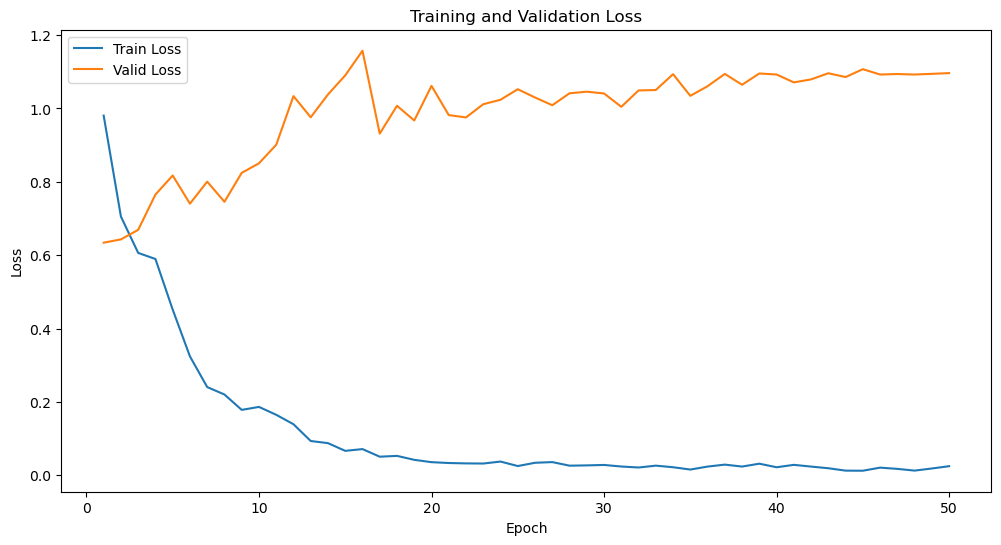

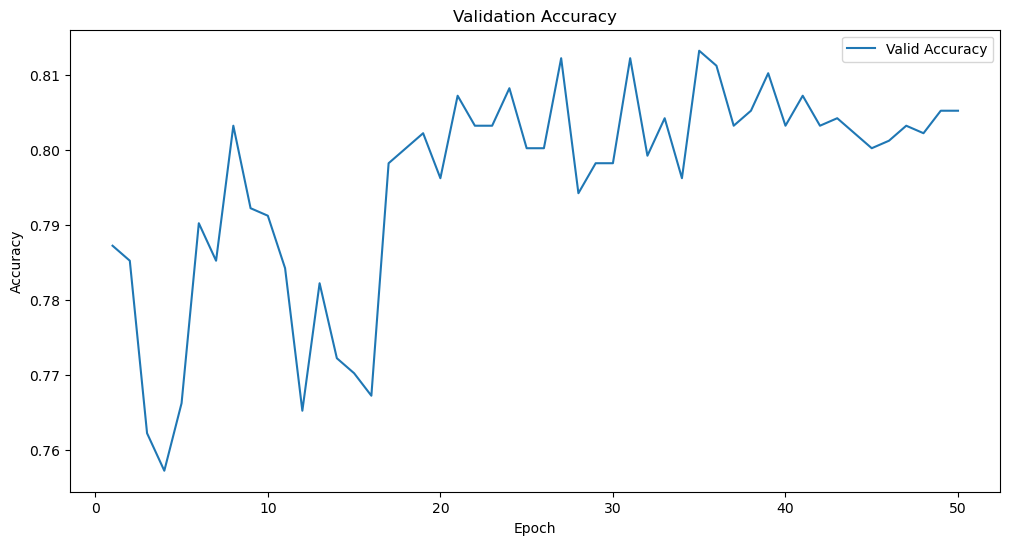

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(x, train_losses, label='Train Loss')
plt.plot(x, valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(x, accuracys, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()